## Molecule Workflow with ESOL example

In [1]:
import keras as ks

just for downloading the some data in place of your data.

In [2]:
%%capture
from kgcnn.data.datasets.ESOLDataset import ESOLDataset
ESOLDataset()

move the data from "~/.kgcnn.datasets.esol" to your local "esol" folder. The ESOL data is just some example data for this notebook.

In [3]:
from kgcnn.data.moleculenet import MoleculeNetDataset

In [4]:
data = MoleculeNetDataset(
    data_directory="esol/",
    dataset_name="esol",
    file_name="delaney-processed.csv",
)

In [5]:
data.prepare_data(
    overwrite=True,
    smiles_column_name="smiles",
    add_hydrogen=True, 
    sanitize=True,
    make_conformers=True, 
    optimize_conformer=True,
    external_program=None, 
    num_workers=None
);

In [6]:
%%capture
from kgcnn.molecule.encoder import OneHotEncoder
data.read_in_memory(
    nodes = [
        'Symbol', 'TotalDegree', 'FormalCharge', 'NumRadicalElectrons', 'Hybridization',
        'IsAromatic', 'IsInRing', 'TotalNumHs', 'CIPCode', "ChiralityPossible", "ChiralTag"
    ],
    encoder_nodes = {
        'Symbol': OneHotEncoder(
            ['B', 'C', 'N', 'O', 'F', 'Si', 'P', 'S', 'Cl', 'As', 'Se', 'Br', 'Te', 'I', 'At'],
            dtype="str"
        ),
        'Hybridization': OneHotEncoder([2, 3, 4, 5, 6]),
        'TotalDegree': OneHotEncoder([0, 1, 2, 3, 4, 5], add_unknown=False),
        'TotalNumHs': OneHotEncoder([0, 1, 2, 3, 4], add_unknown=False),
        'CIPCode': OneHotEncoder(['R', 'S'], add_unknown=False, dtype='str'),
        "ChiralityPossible": OneHotEncoder(["1"], add_unknown=False, dtype='str'),
    },
    edges = ['BondType', 'IsAromatic', 'IsConjugated', 'IsInRing', 'Stereo'],
    encoder_edges = {
        'BondType': OneHotEncoder([1, 2, 3, 12], add_unknown=False),
        'Stereo': OneHotEncoder([0, 1, 2, 3], add_unknown=False)
    },
    graph=['ExactMolWt', 'NumAtoms'],
    encoder_graph = {},
    add_hydrogen=False,
    make_directed=False,
    has_conformers=True,
    sanitize=True,
    compute_partial_charges=None,
    label_column_name="measured log solubility in mols per litre"
)

In [7]:
from kgcnn.graph.preprocessor import SetRange, SetEdgeIndicesReverse
data.map_list(SetRange(max_distance=5.0, in_place=True));
data.map_list(SetEdgeIndicesReverse(in_place=True));
data.map_list(method="count_nodes_and_edges");
data.map_list(**{"method": "count_nodes_and_edges", "total_edges": "total_reverse"});

In [8]:
data[0].keys()

dict_keys(['node_symbol', 'node_number', 'edge_indices', 'edge_number', 'graph_size', 'node_coordinates', 'graph_labels', 'node_attributes', 'edge_attributes', 'graph_attributes', 'range_indices', 'range_attributes', 'edge_indices_reverse', 'total_nodes', 'total_edges', 'total_reverse'])

In [9]:
data.clean("edge_indices")

array([934])

In [10]:
import numpy as np
labels = np.array(data.obtain_property("graph_labels"))
if len(labels.shape) <= 1:
    labels = np.expand_dims(labels, axis=-1)

In [11]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=42, shuffle=True)
train_test_indices = [
    [train_index, test_index] for train_index, test_index in kf.split(X=np.zeros((len(data), 1)), y=labels)]

In [12]:
model_config= {
    "class_name": "make_model",
    "module_name": "kgcnn.literature.DMPNN",
    "config": {
        "name": "DMPNN",
        "inputs": [
            {"shape": (None, 41), "name": "node_attributes", "dtype": "float32"},
            {"shape": (None, 11), "name": "edge_attributes", "dtype": "float32"},
            {"shape": (None, 2), "name": "edge_indices", "dtype": "int64"},
            {"shape": (None, 1), "name": "edge_indices_reverse", "dtype": "int64"},
            {"shape": (), "name": "total_nodes", "dtype": "int64"},
            {"shape": (), "name": "total_edges", "dtype": "int64"},
            {"shape": (), "name": "total_reverse", "dtype": "int64"}
        ],
        "cast_disjoint_kwargs": {},
        "input_node_embedding": {"input_dim": 95, "output_dim": 64},
        "input_edge_embedding": {"input_dim": 5, "output_dim": 64},
        "input_graph_embedding": {"input_dim": 100, "output_dim": 64},
        "pooling_args": {"pooling_method": "scatter_sum"},
        "edge_initialize": {"units": 128, "use_bias": True, "activation": "relu"},
        "edge_dense": {"units": 128, "use_bias": True, "activation": "linear"},
        "edge_activation": {"activation": "relu"},
        "node_dense": {"units": 128, "use_bias": True, "activation": "relu"},
        "verbose": 10, "depth": 5,
        "dropout": {"rate": 0.1},
        "output_embedding": "graph",
        "output_mlp": {
            "use_bias": [True, True, False], "units": [64, 32, 1],
            "activation": ["relu", "relu", "linear"]
        }
    }
}

In [13]:
import time
from kgcnn.models.utils import get_model_class
from keras.optimizers import Adam
from kgcnn.training.scheduler import LinearLearningRateScheduler
from kgcnn.literature.DMPNN import make_model
from kgcnn.data.transform.scaler.molecule import QMGraphLabelScaler
from kgcnn.data.transform.scaler.standard import StandardLabelScaler
from kgcnn.metrics.metrics import ScaledMeanAbsoluteError, ScaledRootMeanSquaredError
from datetime import timedelta

history_list, test_indices_list = [], []
model, hist, x_test, y_test, scaler, atoms_test = None, None, None, None, None, None
splits_done = 0
for i, (train_index, test_index) in enumerate(train_test_indices):
    print("Running training on fold: %s" % i)

    # Make the model for current split using model kwargs from hyperparameter.
    # They are always updated on top of the models default kwargs.
    model = make_model(**model_config["config"])

    # First select training and test graphs from indices, then convert them into tensorflow tensor
    # representation. Which property of the dataset and whether the tensor will be ragged is retrieved from the
    # kwargs of the keras `Input` layers ('name' and 'ragged').
    dataset_train, dataset_test = data[train_index], data[test_index]
    x_train, y_train = dataset_train.tensor(model_config["config"]["inputs"]), labels[train_index]
    x_test, y_test = dataset_test.tensor(model_config["config"]["inputs"]), labels[test_index]
    
    atoms_test = dataset_test.get("node_number")
    atoms_train = dataset_train.get("node_number")
    
    scaler = StandardLabelScaler(with_std=True,with_mean=True, copy=True)
    scaler.fit(y_train, atomic_number=atoms_train)
    y_train = scaler.transform(y_train, atomic_number=atoms_train)
    y_test = scaler.transform(y_test, atomic_number=atoms_test)

    # If scaler was used we add rescaled standard metrics to compile.
    scaler_scale = scaler.get_scaling()
    mae_metric = ScaledMeanAbsoluteError(scaler_scale.shape, name="scaled_mean_absolute_error")
    rms_metric = ScaledRootMeanSquaredError(scaler_scale.shape, name="scaled_root_mean_squared_error")
    if scaler.scale_ is not None:
        mae_metric.set_scale(scaler_scale)
        rms_metric.set_scale(scaler_scale)
    metrics = [mae_metric, rms_metric]

    # Compile model with optimizer and loss
    model.compile(loss="mean_absolute_error", metrics=metrics, optimizer=Adam(learning_rate=5e-04))
    print(model.summary())

    # Build model with reasonable data.
    model.predict(x_test, batch_size=2, steps=2)
    model._compile_metrics.build(y_test, y_test)
    model._compile_loss.build(y_test, y_test)

    # Start and time training
    start = time.process_time()
    hist = model.fit(x_train, y_train,
                     validation_data=(x_test, y_test),
                     batch_size=32, 
                     epochs=300, 
                     validation_freq=10, 
                     # Change to verbose = 2 to see progress
                     verbose=0,
                     callbacks= [
                         LinearLearningRateScheduler(
                             learning_rate_start=0.001, learning_rate_stop=1e-05, epo_min=100, epo=300)
                     ])
    stop = time.process_time()
    print("Print Time for training: ", str(timedelta(seconds=stop - start)))

    # Get loss from history
    history_list.append(hist)
    test_indices_list.append([train_index, test_index])
    splits_done = splits_done + 1

Running training on fold: 0


Model: "DMPNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ node_attributes (InputLayer)  │ (None, None, 41)          │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ edge_indices (InputLayer)     │ (None, None, 2)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ total_nodes (InputLayer)      │ (None)                    │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ total_edges (InputLayer)      │ (None)                    │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cast_batched_indices_to_disj… │ [(None, 41), (2, None),   │               0 │ node_attributes[0][0],     │
│ (CastBatchedIndicesToDisjoin… │ (None), (None), (None),   │                 │ edge_indices[0][0],        │
│                               │ (None), (None), (None)]   │                 │ total_nodes[0][0],         │
│                               │                           │                 │ total_edges[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ edge_attributes (InputLayer)  │ (None, None, 11)          │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gather_nodes_outgoing         │ (None, 41)                │               0 │ cast_batched_indices_to_d… │
│ (GatherNodesOutgoing)         │                           │                 │ cast_batched_indices_to_d… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cast_batched_attributes_to_d… │ [(None, 11), (None),      │               0 │ edge_attributes[0][0],     │
│ (CastBatchedAttributesToDisj… │ (None), (None)]           │                 │ total_edges[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 52)                │               0 │ gather_nodes_outgoing[0][… │
│                               │                           │                 │ cast_batched_attributes_t… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ edge_indices_reverse          │ (None, None, 1)           │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ total_reverse (InputLayer)    │ (None)                    │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 128)               │           6,784 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cast_batched_indices_to_disj… │ [(None, 2), (1, None),    │               0 │ edge_indices[0][0],        │
│ (CastBatchedIndicesToDisjoin… │ (None), (None), (None),   │                 │ edge_indices_reverse[0][0… │
│                               │ (None), (None), (None)]   │               

 Total params: 55,424 (216.50 KB)

 Trainable params: 55,424 (216.50 KB)

 Non-trainable params: 0 (0.00 B)

None
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step 
Print Time for training:  0:02:24.984375
Running training on fold: 1


Model: "DMPNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ node_attributes (InputLayer)  │ (None, None, 41)          │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ edge_indices (InputLayer)     │ (None, None, 2)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ total_nodes (InputLayer)      │ (None)                    │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ total_edges (InputLayer)      │ (None)                    │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cast_batched_indices_to_disj… │ [(None, 41), (2, None),   │               0 │ node_attributes[0][0],     │
│ (CastBatchedIndicesToDisjoin… │ (None), (None), (None),   │                 │ edge_indices[0][0],        │
│                               │ (None), (None), (None)]   │                 │ total_nodes[0][0],         │
│                               │                           │                 │ total_edges[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ edge_attributes (InputLayer)  │ (None, None, 11)          │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gather_nodes_outgoing_6       │ (None, 41)                │               0 │ cast_batched_indices_to_d… │
│ (GatherNodesOutgoing)         │                           │                 │ cast_batched_indices_to_d… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cast_batched_attributes_to_d… │ [(None, 11), (None),      │               0 │ edge_attributes[0][0],     │
│ (CastBatchedAttributesToDisj… │ (None), (None)]           │                 │ total_edges[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_2 (Concatenate)   │ (None, 52)                │               0 │ gather_nodes_outgoing_6[0… │
│                               │                           │                 │ cast_batched_attributes_t… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ edge_indices_reverse          │ (None, None, 1)           │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ total_reverse (InputLayer)    │ (None)                    │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 128)               │           6,784 │ concatenate_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cast_batched_indices_to_disj… │ [(None, 2), (1, None),    │               0 │ edge_indices[0][0],        │
│ (CastBatchedIndicesToDisjoin… │ (None), (None), (None),   │                 │ edge_indices_reverse[0][0… │
│                               │ (None), (None), (None)]   │               

 Total params: 55,424 (216.50 KB)

 Trainable params: 55,424 (216.50 KB)

 Non-trainable params: 0 (0.00 B)

None
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Print Time for training:  0:02:24.656250
Running training on fold: 2


Model: "DMPNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ node_attributes (InputLayer)  │ (None, None, 41)          │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ edge_indices (InputLayer)     │ (None, None, 2)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ total_nodes (InputLayer)      │ (None)                    │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ total_edges (InputLayer)      │ (None)                    │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cast_batched_indices_to_disj… │ [(None, 41), (2, None),   │               0 │ node_attributes[0][0],     │
│ (CastBatchedIndicesToDisjoin… │ (None), (None), (None),   │                 │ edge_indices[0][0],        │
│                               │ (None), (None), (None)]   │                 │ total_nodes[0][0],         │
│                               │                           │                 │ total_edges[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ edge_attributes (InputLayer)  │ (None, None, 11)          │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gather_nodes_outgoing_12      │ (None, 41)                │               0 │ cast_batched_indices_to_d… │
│ (GatherNodesOutgoing)         │                           │                 │ cast_batched_indices_to_d… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cast_batched_attributes_to_d… │ [(None, 11), (None),      │               0 │ edge_attributes[0][0],     │
│ (CastBatchedAttributesToDisj… │ (None), (None)]           │                 │ total_edges[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_4 (Concatenate)   │ (None, 52)                │               0 │ gather_nodes_outgoing_12[… │
│                               │                           │                 │ cast_batched_attributes_t… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ edge_indices_reverse          │ (None, None, 1)           │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ total_reverse (InputLayer)    │ (None)                    │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_6 (Dense)               │ (None, 128)               │           6,784 │ concatenate_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cast_batched_indices_to_disj… │ [(None, 2), (1, None),    │               0 │ edge_indices[0][0],        │
│ (CastBatchedIndicesToDisjoin… │ (None), (None), (None),   │                 │ edge_indices_reverse[0][0… │
│                               │ (None), (None), (None)]   │               

 Total params: 55,424 (216.50 KB)

 Trainable params: 55,424 (216.50 KB)

 Non-trainable params: 0 (0.00 B)

None
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Print Time for training:  0:02:25.218750
Running training on fold: 3


Model: "DMPNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ node_attributes (InputLayer)  │ (None, None, 41)          │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ edge_indices (InputLayer)     │ (None, None, 2)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ total_nodes (InputLayer)      │ (None)                    │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ total_edges (InputLayer)      │ (None)                    │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cast_batched_indices_to_disj… │ [(None, 41), (2, None),   │               0 │ node_attributes[0][0],     │
│ (CastBatchedIndicesToDisjoin… │ (None), (None), (None),   │                 │ edge_indices[0][0],        │
│                               │ (None), (None), (None)]   │                 │ total_nodes[0][0],         │
│                               │                           │                 │ total_edges[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ edge_attributes (InputLayer)  │ (None, None, 11)          │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gather_nodes_outgoing_18      │ (None, 41)                │               0 │ cast_batched_indices_to_d… │
│ (GatherNodesOutgoing)         │                           │                 │ cast_batched_indices_to_d… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cast_batched_attributes_to_d… │ [(None, 11), (None),      │               0 │ edge_attributes[0][0],     │
│ (CastBatchedAttributesToDisj… │ (None), (None)]           │                 │ total_edges[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_6 (Concatenate)   │ (None, 52)                │               0 │ gather_nodes_outgoing_18[… │
│                               │                           │                 │ cast_batched_attributes_t… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ edge_indices_reverse          │ (None, None, 1)           │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ total_reverse (InputLayer)    │ (None)                    │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_9 (Dense)               │ (None, 128)               │           6,784 │ concatenate_6[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cast_batched_indices_to_disj… │ [(None, 2), (1, None),    │               0 │ edge_indices[0][0],        │
│ (CastBatchedIndicesToDisjoin… │ (None), (None), (None),   │                 │ edge_indices_reverse[0][0… │
│                               │ (None), (None), (None)]   │               

 Total params: 55,424 (216.50 KB)

 Trainable params: 55,424 (216.50 KB)

 Non-trainable params: 0 (0.00 B)

None
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Print Time for training:  0:02:24.843750
Running training on fold: 4


Model: "DMPNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ node_attributes (InputLayer)  │ (None, None, 41)          │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ edge_indices (InputLayer)     │ (None, None, 2)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ total_nodes (InputLayer)      │ (None)                    │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ total_edges (InputLayer)      │ (None)                    │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cast_batched_indices_to_disj… │ [(None, 41), (2, None),   │               0 │ node_attributes[0][0],     │
│ (CastBatchedIndicesToDisjoin… │ (None), (None), (None),   │                 │ edge_indices[0][0],        │
│                               │ (None), (None), (None)]   │                 │ total_nodes[0][0],         │
│                               │                           │                 │ total_edges[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ edge_attributes (InputLayer)  │ (None, None, 11)          │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gather_nodes_outgoing_24      │ (None, 41)                │               0 │ cast_batched_indices_to_d… │
│ (GatherNodesOutgoing)         │                           │                 │ cast_batched_indices_to_d… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cast_batched_attributes_to_d… │ [(None, 11), (None),      │               0 │ edge_attributes[0][0],     │
│ (CastBatchedAttributesToDisj… │ (None), (None)]           │                 │ total_edges[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_8 (Concatenate)   │ (None, 52)                │               0 │ gather_nodes_outgoing_24[… │
│                               │                           │                 │ cast_batched_attributes_t… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ edge_indices_reverse          │ (None, None, 1)           │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ total_reverse (InputLayer)    │ (None)                    │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_12 (Dense)              │ (None, 128)               │           6,784 │ concatenate_8[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cast_batched_indices_to_disj… │ [(None, 2), (1, None),    │               0 │ edge_indices[0][0],        │
│ (CastBatchedIndicesToDisjoin… │ (None), (None), (None),   │                 │ edge_indices_reverse[0][0… │
│                               │ (None), (None), (None)]   │               

 Total params: 55,424 (216.50 KB)

 Trainable params: 55,424 (216.50 KB)

 Non-trainable params: 0 (0.00 B)

None
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Print Time for training:  0:02:24.640625


Epoch 246/300
29/29 - 1s - loss: 0.0700 - scaled_mean_absolute_error: 0.1470 - scaled_root_mean_squared_error: 0.2065 - lr: 2.8225e-04 - 571ms/epoch - 20ms/step
Epoch 247/300
29/29 - 1s - loss: 0.0680 - scaled_mean_absolute_error: 0.1427 - scaled_root_mean_squared_error: 0.2090 - lr: 2.7730e-04 - 649ms/epoch - 22ms/step
Epoch 248/300
29/29 - 1s - loss: 0.0695 - scaled_mean_absolute_error: 0.1458 - scaled_root_mean_squared_error: 0.2157 - lr: 2.7235e-04 - 686ms/epoch - 24ms/step
Epoch 249/300
29/29 - 1s - loss: 0.0663 - scaled_mean_absolute_error: 0.1392 - scaled_root_mean_squared_error: 0.2063 - lr: 2.6740e-04 - 572ms/epoch - 20ms/step
Epoch 250/300
29/29 - 1s - loss: 0.0677 - scaled_mean_absolute_error: 0.1423 - scaled_root_mean_squared_error: 0.2087 - val_loss: 0.2113 - val_scaled_mean_absolute_error: 0.4437 - val_scaled_root_mean_squared_error: 0.6105 - lr: 2.6245e-04 - 684ms/epoch - 24ms/step
Epoch 251/300
29/29 - 1s - loss: 0.0657 - scaled_mean_absolute_error: 0.1380 - scaled_root

Epoch 294/300
29/29 - 1s - loss: 0.0552 - scaled_mean_absolute_error: 0.1159 - scaled_root_mean_squared_error: 0.1771 - lr: 4.4650e-05 - 553ms/epoch - 19ms/step
Epoch 295/300
29/29 - 1s - loss: 0.0534 - scaled_mean_absolute_error: 0.1121 - scaled_root_mean_squared_error: 0.1707 - lr: 3.9700e-05 - 583ms/epoch - 20ms/step
Epoch 296/300
29/29 - 1s - loss: 0.0547 - scaled_mean_absolute_error: 0.1149 - scaled_root_mean_squared_error: 0.1717 - lr: 3.4750e-05 - 551ms/epoch - 19ms/step
Epoch 297/300
29/29 - 1s - loss: 0.0517 - scaled_mean_absolute_error: 0.1085 - scaled_root_mean_squared_error: 0.1651 - lr: 2.9800e-05 - 541ms/epoch - 19ms/step
Epoch 298/300
29/29 - 1s - loss: 0.0542 - scaled_mean_absolute_error: 0.1137 - scaled_root_mean_squared_error: 0.1735 - lr: 2.4850e-05 - 591ms/epoch - 20ms/step
Epoch 299/300
29/29 - 1s - loss: 0.0507 - scaled_mean_absolute_error: 0.1064 - scaled_root_mean_squared_error: 0.1671 - lr: 1.9900e-05 - 538ms/epoch - 19ms/step
Epoch 300/300
29/29 - 1s - loss: 0

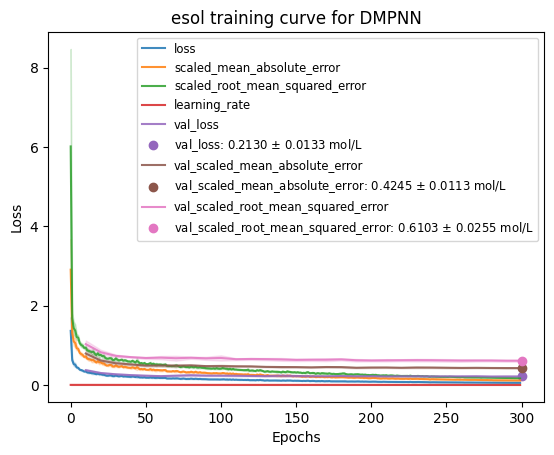

In [14]:
from kgcnn.utils.plots import plot_train_test_loss, plot_predict_true

plot_train_test_loss(history_list, loss_name=None, val_loss_name=None,
                     model_name="DMPNN", data_unit="mol/L", dataset_name="esol",
                     filepath="", file_name=f"loss.png");

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


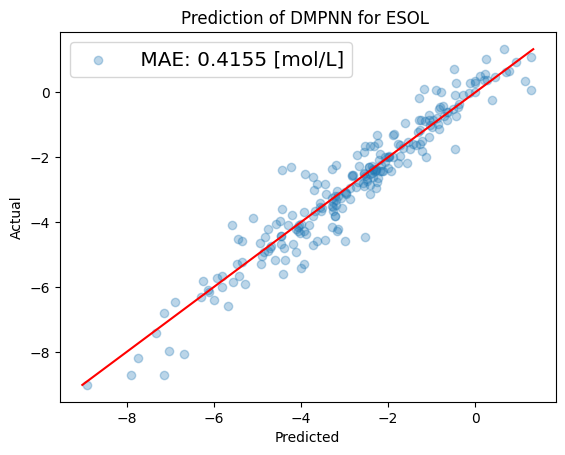

In [15]:
# Plot prediction for the last split.
predicted_y = model.predict(x_test)
true_y = y_test

# Predictions must be rescaled to original values.
predicted_y = scaler.inverse_transform(predicted_y)
true_y = scaler.inverse_transform(true_y)

# Plotting the prediction vs. true test targets for last split. Note for classification this is also done but
# can be ignored.
plot_predict_true(predicted_y, true_y,
                  filepath="", data_unit="mol/L",
                  model_name="DMPNN", dataset_name="ESOL",
                  file_name=f"predict.png");